In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

In [2]:
stringSST = "300" ##295, 300 or 305
n_days = 1

file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_SAM_large300_2D_irtb.nc'
file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-SAM_large300_2D_irtb.dat.gz'
sam_file = "/bdd/MT_WORKSPACE/MCS/RCE/SAM/INPUTS/v2023_05/SAM_RCE_large300_2D_pr.nc"

## Open Precip data under ds

In [3]:
da = xr.open_dataarray(sam_file)
## isel n_days
da = da.isel(time=slice(0, n_days*48))
da.head()

<xarray.DataArray 'pr' (time: 5, latitude: 5, longitude: 5)>
[125 values with dtype=float32]
Dimensions without coordinates: time, latitude, longitude
Attributes:
    units:      mm/h
    long_name:  pr

In [4]:
da

<xarray.DataArray 'pr' (time: 48, latitude: 128, longitude: 2048)>
[12582912 values with dtype=float32]
Dimensions without coordinates: time, latitude, longitude
Attributes:
    units:      mm/h
    long_name:  pr

In [5]:
filename = 'dist_SAM_Native_Prec_sizemax_1e7.pkl' # used for import or saving the object
path = '/homedata/mcarenso/distrib_nd5/test10day/'  # my desired directory path

# Check if the file exists
if os.path.isfile(os.path.join(path, filename)):
    # File exists, load the object
    with open(os.path.join(path, filename), 'rb') as file:
        dist_SAM_Prec = pickle.load(file)
else:
    # File doesn't exist, create the object
    dist_SAM_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 5, fill_last_decade=True)
    dist_SAM_Prec.computeDistribution(sample = da.to_numpy().flatten())
    dist_SAM_Prec.storeSamplePoints(sample = da.to_numpy().flatten(), sizemax = int(1e7))

    # Save the object as a file
    with open(os.path.join(path, filename), 'wb') as file:
        pickle.dump(dist_SAM_Prec, file)

## Open MCS_list and extract the 6hours 10hours MCS and pot some of their data distrib

In [6]:
## Import MCS list and prepare label list

from load_TOOCAN_DYAMOND_modif_BenAndMax import load_TOOCAN_DYAMOND
MCS = load_TOOCAN_DYAMOND(file_tracking)
MCS_labels = [MCS[i].label for i in range(len(MCS))]

## function to retrieve the indexes in MCS by MCS labels, could be put in myFuncs but need label_list from the tracking file

def idx_by_label(labels, label_list = MCS_labels):
    idxs = [label_list.index(label) for label in labels]
    return idxs

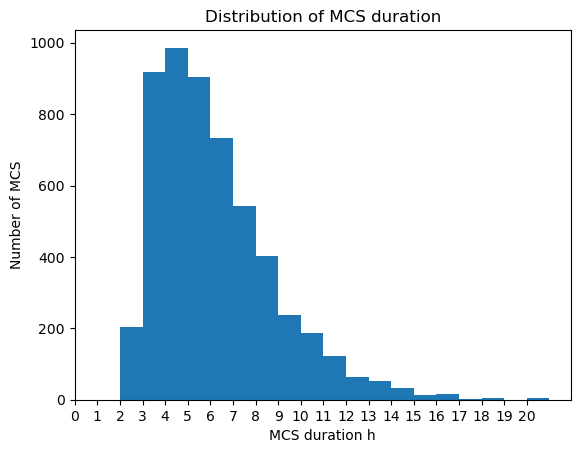

In [7]:
%matplotlib inline
MCS_durations = [MCS[i].duration for i in range(len(MCS))]
# plot the distribution of MCS duration
plt.hist([MCS[i].duration for i in range(len(MCS))], bins = (max(MCS_durations)- min(MCS_durations))//2)

#xticks are half hourly make them hourly
tick_locs = np.arange(0, max(MCS_durations), 2)
tick_labels = np.arange(0, max(MCS_durations),2)//2
plt.xticks(tick_locs, tick_labels)

plt.xlabel("MCS duration h")
plt.ylabel("Number of MCS")
plt.title("Distribution of MCS duration")
plt.show()

In [8]:
MCS_2h_to_10h = [MCS[i] for i in range(len(MCS)) if MCS[i].duration in np.arange(4, 21, 1).astype(int).tolist()]
MCS_2h_to_10h_labels = [MCS_2h_to_10h[i].label for i in range(len(MCS_2h_to_10h))]

## Create masks (bools or labels)

In [9]:
## label_mask contains the label of the MCS over the map
label_mask = xr.open_dataarray(file_seg).isel(time=slice(48*n_days))

label_2h_to_10h_mask = label_mask.where(label_mask.isin(MCS_2h_to_10h_labels))

mask_2h_to_10h = ~label_2h_to_10h_mask.where(label_2h_to_10h_mask.isnull(), False).isnull()
# da contains the native precipitation values over the map filtered where there is an MCS
# Prec = ds["Prec"].where(mask_6h)

# Compute Analysis of Normalzied Age of MCS over XPrecip bins for MCS around 6h lifetime

In [10]:
filename = "AgeAnalysis.pkl"
path_data = "/homedata/mcarenso/Stage2023/SAM/300K/test10day/"
## if file exists, load it
if os.path.isfile(path_data + filename):
    with open(os.path.join(path_data, filename), 'rb') as file:
        output = pickle.load(file)
        
else : 
    ## compute the age analysis
    output = dist_SAM_Prec.computeAgeAnalysisOverBins(sample = da.values, MCS_list = MCS_2h_to_10h, label = label_2h_to_10h_mask.compute().values, sizemax = int(1e5))
    
    ## save the output
    with open(os.path.join(path_data, filename), 'wb') as file:  
        pickle.dump(output, file)   

## Import data loaded by the python job

In [11]:
Ages_over_bins, Ages_of_Xprecip, Xprecip_over_ages, Xprecip_counts, Ages_per_duration, Ages_of_MaxPrecip, MaxPrecip_over_ages, MaxPrecip_MCS_counts = output

## Plot Ages over bins and save them

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


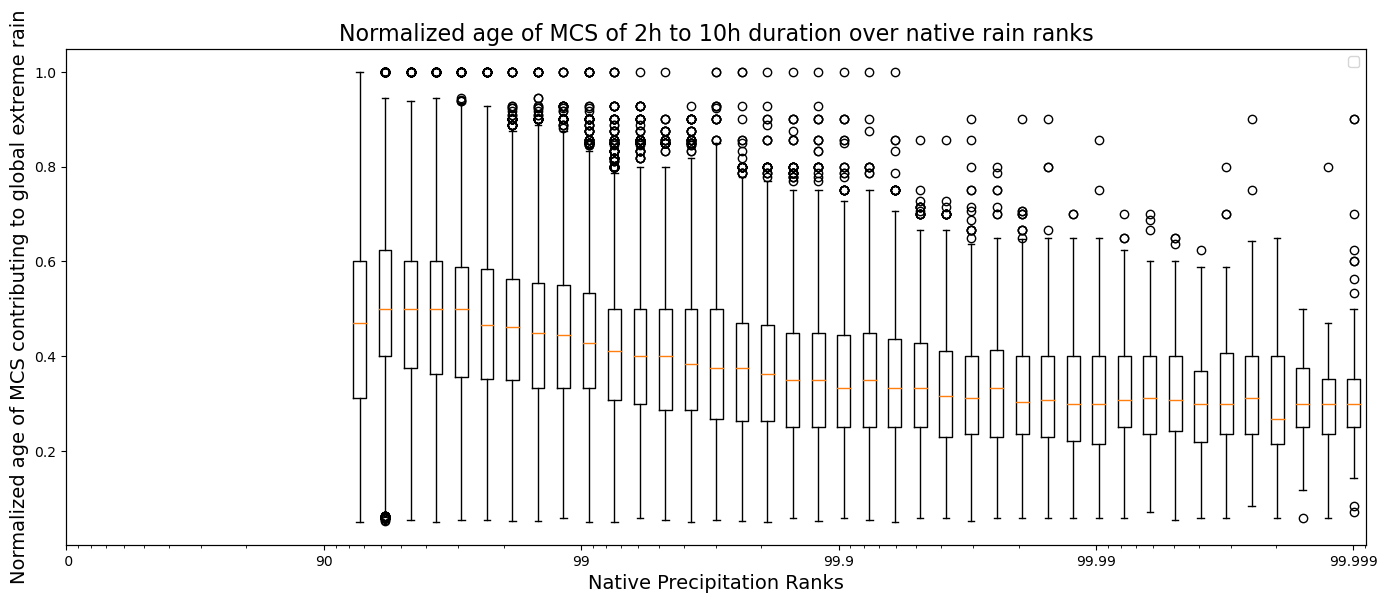

In [12]:
%matplotlib inline
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize= (14, 6))
x=dist_SAM_Prec.ranks

setXaxisIL(ax, x)
ax_show = ax.twiny()
ax_show.boxplot(Ages_over_bins)
ax_show.set_xticks([])

ax.set_xlabel("Native Precipitation Ranks", fontsize = 14)

ax.set_ylabel("Normalized age of MCS contributing to global extreme rain", fontsize = 14)
plt.legend()
plt.title("Normalized age of MCS of 2h to 10h duration over native rain ranks", fontsize = 16)
plt.tight_layout()
#plt.savefig("Ages_over_bins.png", dpi = 300)
plt.show()

## Plot Xprecip over ages for 2h-10h MCS

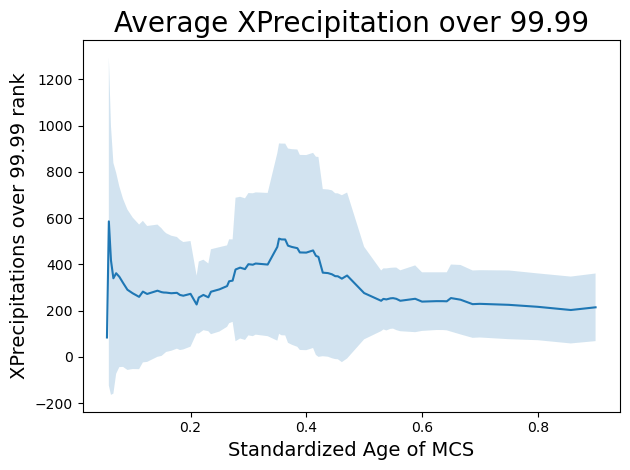

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate moving average
window_width = 20  # Change this value to adjust the width of the moving average
rolling_average = pd.Series(Xprecip_over_ages).rolling(window=window_width, min_periods=1).mean()
rolling_std = pd.Series(Xprecip_over_ages).rolling(window=window_width, min_periods=1).std()

# Plot the moving average
plt.plot(Ages_of_Xprecip, rolling_average)
plt.fill_between(Ages_of_Xprecip, rolling_average - rolling_std, rolling_average + rolling_std, alpha=0.2)
plt.xlabel('Standardized Age of MCS', fontsize=14)
plt.ylabel('XPrecipitations over 99.99 rank', fontsize=14)
plt.title('Average XPrecipitation over 99.99', fontsize=20)
plt.tight_layout()
#plt.savefig(output_MESONH_path + "Xprecip_over_ages_width20.png", dpi = 300)
plt.show()

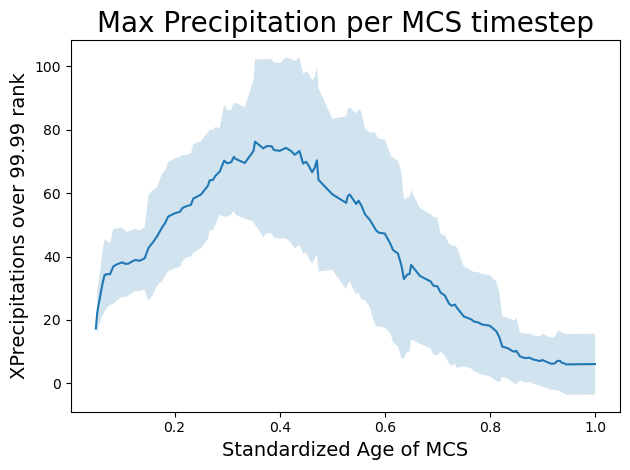

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate moving average
window_width = 20  # Change this value to adjust the width of the moving average
rolling_average = pd.Series(MaxPrecip_over_ages).rolling(window=window_width, min_periods=1).mean()
rolling_std = pd.Series(MaxPrecip_over_ages).rolling(window=window_width, min_periods=1).std()

# Plot the moving average
plt.plot(Ages_of_MaxPrecip, rolling_average)
plt.fill_between(Ages_of_MaxPrecip, rolling_average - rolling_std, rolling_average + rolling_std, alpha=0.2)
plt.xlabel('Standardized Age of MCS', fontsize=14)
plt.ylabel('XPrecipitations over 99.99 rank', fontsize=14)
plt.title('Max Precipitation per MCS timestep', fontsize=20)
plt.tight_layout()
#plt.savefig(output_MESONH_path + "Xprecip_over_ages_width20.png", dpi = 300)
plt.show()

## Plot #MCS over ages for 2h-10h MCS

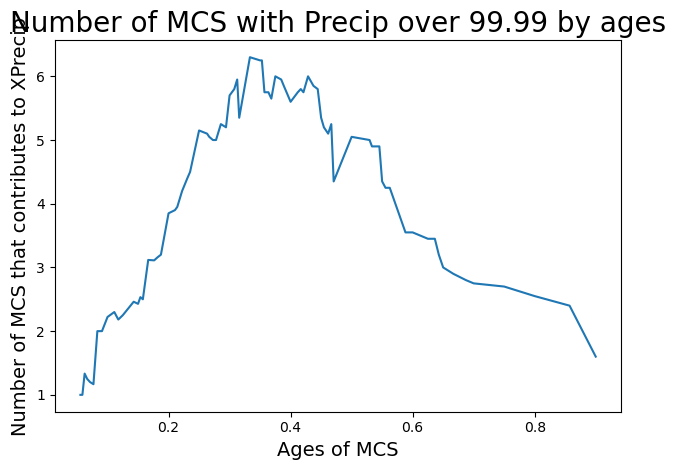

In [15]:

# Calculate moving average
window_width = 20  # Change this value to adjust the width of the moving average
rolling_average = pd.Series(Xprecip_counts).rolling(window=window_width, min_periods=1).mean()

plt.plot(Ages_of_Xprecip, rolling_average)
plt.xlabel('Ages of MCS', fontsize = 14)
plt.ylabel('Number of MCS that contributes to XPrecip', fontsize = 14)
plt.title('Number of MCS with Precip over 99.99 by ages', fontsize = 20)
plt.tight_layout()
#plt.savefig(output_path + "Xprecip_counts_over_ages_width20.png", dpi = 300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


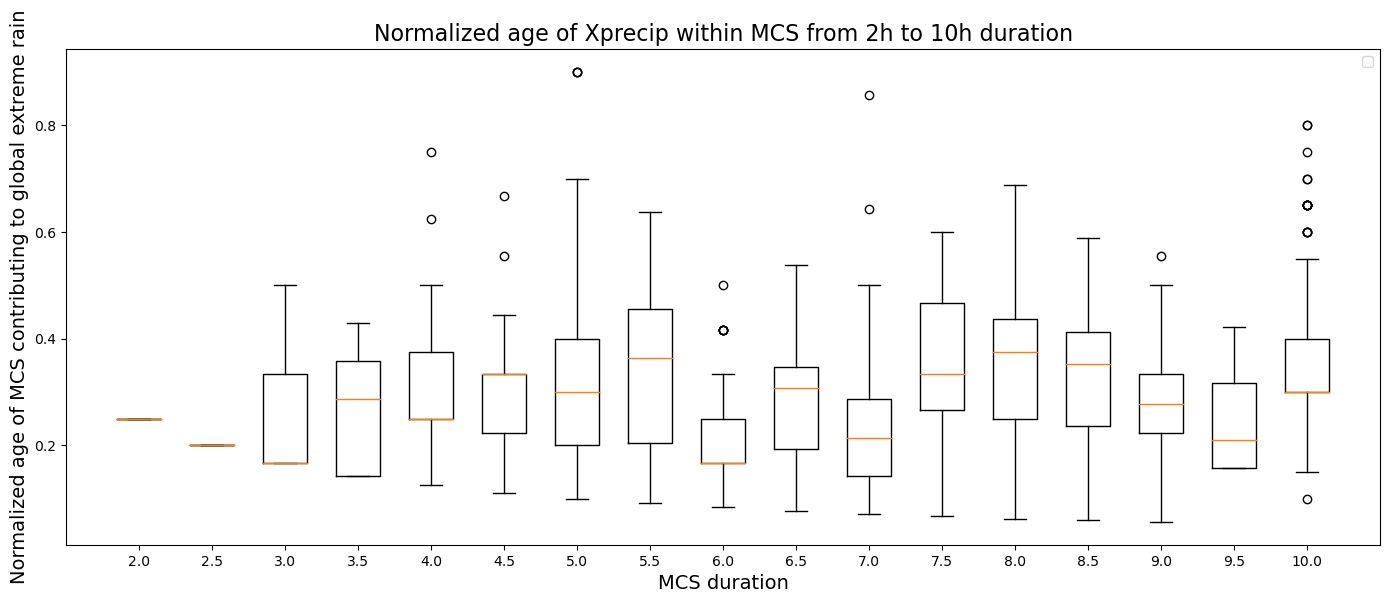

In [16]:
%matplotlib inline

MCS_duration_2h_to_10h = np.arange(2, 10.5, 1/2)

fig, ax = plt.subplots(nrows = 1, ncols=1, figsize= (14, 6))
ax.boxplot(Ages_per_duration, positions = MCS_duration_2h_to_10h, widths = 0.3)


ax.set_xlabel("MCS duration", fontsize = 14)
ax.set_ylabel("Normalized age of MCS contributing to global extreme rain", fontsize = 14)
plt.legend()
plt.title("Normalized age of Xprecip within MCS from 2h to 10h duration", fontsize = 16)
plt.tight_layout()
#plt.savefig(output_path + "Ages_per_duration.png", dpi = 300)
plt.show()


## New ensemble : Maximal precipitation per MCS


In [17]:
MCS_list = MCS_2h_to_10h
label_2h_to_10h_mask.shape
n_days = 25
sim_path = "/bdd/MT_WORKSPACE/MCS/RCE/SAM/INPUTS/v2023_05/SAM_RCE_large300_2D_pr.nc"
Precip = xr.open_dataset(sim_path, engine= "netcdf4").isel(time=slice(48*n_days))

file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_SAM_large300_2D_irtb.nc'
file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-SAM_large300_2D_irtb.dat.gz'

## Import MCS list and prepare label list
from load_TOOCAN_DYAMOND_modif_BenAndMax import load_TOOCAN_DYAMOND
MCS = load_TOOCAN_DYAMOND(file_tracking)
MCS_labels = [MCS[i].label for i in range(len(MCS))]

## function to retrieve the indexes in MCS by MCS labels, could be put in myFuncs but need label_list from the tracking file
def idx_by_label(labels, label_list = MCS_labels):
    ## check if labels is a list or a single label
    if type(labels) == int:
        idx = label_list.index(labels)
        return idx
    else : 
        idxs = [label_list.index(label) for label in labels]
        return idxs

MCS_2h_to_10h = [MCS[i] for i in range(len(MCS)) if MCS[i].duration in np.arange(4, 21, 1).astype(int).tolist()]
MCS_2h_to_10h_labels = [MCS_2h_to_10h[i].label for i in range(len(MCS_2h_to_10h))]
        
## label_mask contains the label of the MCS over the map
label_mask = xr.open_dataarray(file_seg, chunks = {'time' :48, 'longitude' : 32, 'latitude' : 32}).isel(time=slice(48*n_days)).astype(int) 
## adapt label_mask to 2h_10h MCS
label_2h_to_10h_mask = label_mask.where(label_mask.isin(MCS_2h_to_10h_labels))

mask_2h_to_10h = ~label_2h_to_10h_mask.where(label_2h_to_10h_mask.isnull(), False).isnull()

In [18]:
filename = "Max_Precip_per_MCS_data_and_dist.pkl"
output_path = "/homedata/mcarenso/Stage2023/SAM/"+stringSST+"K/MaxPrecipAnalysis/test_1day/"
import time
t0 = time.time()
if os.path.isfile(os.path.join(output_path, filename)):
    # File exists, load the object
    with open(os.path.join(output_path, filename), 'rb') as file:
        dist_Max_Prec, Max_Precip, Max_Precip_index, Max_Precip_label = pickle.load(file)
else:
    Max_Precip = []  # Initialize the list to store maximum values
    Max_Precip_index = []  # Initialize the list to store first indices
    Max_Precip_label = [] # Store corresponding MCS label
    
    for i,mcs in enumerate(MCS_2h_to_10h):
        reduced_mask = label_2h_to_10h_mask[mcs.TimeInit:(mcs.TimeInit+mcs.duration) ,:,:].values
        reduced_precip = Precip['pr'][mcs.TimeInit:(mcs.TimeInit+mcs.duration) ,:,:].values
        ## filter mask on time from timeinit to timeinit + duration        
        precip_values = np.where(reduced_mask == mcs.label, reduced_precip, np.nan)
        

        if not np.all(np.isnan(precip_values)):  # If the array is not full of NaN values
            max_value = np.nanmax(precip_values)
            max_value_index = np.argwhere((reduced_mask == mcs.label) & (reduced_precip == max_value))
            max_value_index[0]+=mcs.TimeInit
            if not np.isnan(max_value): # Maybe unnecessary there
                Max_Precip_index.append(max_value_index)
                Max_Precip_label.append(mcs.label)
                Max_Precip.append(max_value)
        print("Distrib and data creation completed at ", (i+1)/len(MCS_2h_to_10h)*100, "%")
        print("Time elapsed : ", time.time()-t0, "s")
        print("time left estimate :", (time.time()-t0)/(i+1)*(len(MCS_2h_to_10h)-(i+1)), "s")        

    Max_Precip = np.array(Max_Precip)
    dist_Max_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
    dist_Max_Prec.computeDistribution(sample = Max_Precip)
    dist_Max_Prec.storeSamplePoints(sample =  Max_Precip, sizemax = int(1e7))

    dist_and_data = (dist_Max_Prec, Max_Precip, Max_Precip_index, Max_Precip_label)
    
    # Save the object as a file
    with open(os.path.join(output_path, filename), 'wb') as file:
        pickle.dump(dist_and_data, file)


In [40]:
from myFuncs import Age
Ages_of_MaxPrecip_over_bins = [[] for _ in dist_Max_Prec.bin_locations]

for i, bin_loc in enumerate(dist_Max_Prec.bin_locations):
    for idx in bin_loc:
        label = Max_Precip_label[idx]
        time = Max_Precip_index[idx][0][0]
        ages, durations, timeinits = Age(label, time, MCS_2h_to_10h[idx_by_label(label, label_list=MCS_2h_to_10h_labels)])
        if ages is not None:
            if type(ages) == list:        
                for age in ages : 
                    Ages_of_MaxPrecip_over_bins[i].append(age)
            elif type(ages) == np.float64:
                Ages_of_MaxPrecip_over_bins[i].append(ages)

In [44]:
Ages_of_MaxPrecip_over_bins[20]

[]

## Check nan over MCS (I'm insecure, am I not)

In [19]:
from myFuncs import count_rel_nan

path_data = '/homedata/mcarenso/data/'  # my desired directory path
filename = 'perc_MCS_over_rain_'+stringSST+'.pkl'

# check if perc_MCS_over_rain is already computed and saved in homedata 
if os.path.isfile(os.path.join(path_data, filename)):
    # File exists, load the object
    with open(os.path.join(path_data, filename), 'rb') as file:
        perc_MCS_over_rain = pickle.load(file)

check that the curve bounds match
x bounds: 0.0 99.99900000000001
y bounds: 0.0 116.35764019770318



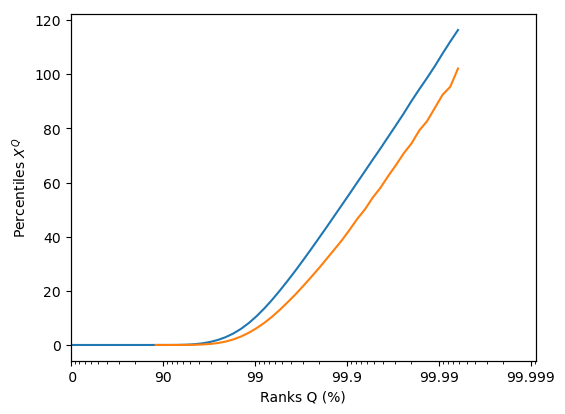

In [20]:
%matplotlib inline
fig,ax = plt.subplots(ncols=1,figsize=(6,4.5))

ranks = dist_SAM_Prec.ranks
perc = dist_SAM_Prec.percentiles

#--- on IL x axis
ax_show = ax.twiny()

#- set frame
setXaxisIL(ax,ranks)

#- show data
showData(ax_show,ranks,perc, rankmin=0, rankmax = 99.9999)
showData(ax_show, ranks, perc*perc_MCS_over_rain, rankmin=0, rankmax = 99.9999)

#- labels
ax.set_xlabel('Ranks Q (%)')
ax.set_ylabel('Percentiles $X^Q$')

print('check that the curve bounds match')
print('x bounds:',ranks[0],ranks[-1])
print('y bounds:',perc[0],perc[-1])
print()

In [21]:
### check the distribution of the native precipitations for SAM ICON and MESONH 
SAM_distrib_path = "/homedata/mcarenso/Stage2023/SAM/300K/Distribution_Precip_5decades.pkl"
ICON_distrib_path = "/homedata/mcarenso/Stage2023/ICON/300K/Distribution_Precip_5decades.pkl"
MESONH_distrib_path = "/homedata/mcarenso/Stage2023/MESONH/300K/Distribution_Precip_5decades.pkl"

In [22]:
## for each path check if file exists and load it into a variable with coherent name 
if os.path.isfile(SAM_distrib_path):
    # File exists, load the object
    with open(SAM_distrib_path, 'rb') as file:
        SAM_distrib = pickle.load(file)
else:    
    print('SAM_distrib_path does not exist')

if os.path.isfile(ICON_distrib_path):
    # File exists, load the object
    with open(ICON_distrib_path, 'rb') as file:
        ICON_distrib = pickle.load(file)
else:
    print('ICON_distrib_path does not exist')
    
if os.path.isfile(MESONH_distrib_path):
    # File exists, load the object
    with open(MESONH_distrib_path, 'rb') as file:
        MESONH_distrib = pickle.load(file)
else:
    print('MESONH_distrib_path does not exist')
    

In [23]:
file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_SAM_large300_2D_irtb.nc'
file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-SAM_large300_2D_irtb.dat.gz'
sim_path = "/bdd/MT_WORKSPACE/MCS/RCE/SAM/INPUTS/v2023_05/SAM_RCE_large300_2D_pr.nc"
output_path = "/homedata/mcarenso/Stage2023/SAM/300K/"

In [24]:
SAM_Prec= xr.open_dataarray(sim_path).values.flatten()

In [25]:
dist_SAM_Prec = pickle.load(open(output_path+'Distribution_Precip_5decades.pkl', 'rb'))

In [26]:
np.min(SAM_Prec[SAM_Prec>0])

0.0011692168